# Calculation of carotenoid pump-probe spectra

In [1]:
from quantarhei import Molecule, Aggregate
from quantarhei import energy_units, convert
from quantarhei import CorrelationFunction, TimeAxis
from quantarhei import SpectralDensity
from quantarhei.spectroscopy.abscalculator import LinSpectrumCalculator
from quantarhei import Mode
import numpy as np

Specify pump-probe time axis and temperature
---------

In [2]:
Nr2D = 1500                         # Number of T1, T3 time steps
t2D = TimeAxis(0.0, Nr2D, 0.5)      # T1, T3 time axis
time_so = TimeAxis(0.0, 300, 40.0)  # Evolution time for the evolution superoperator - T2 time axis
timestep = 0.4
tmax = int((time_so.max + t2D.max + t2D.step)/timestep)
time = TimeAxis(0.0, tmax, timestep) # time axis for correlation function
Temp = 300 # K

If desired specify the excitation pulse (assuming delta pulse in time domain but gaussian in frequency domain)

In [3]:
from quantarhei import DFunction

# Definition of pump gaussian pulse
freq_pulse = time.get_FrequencyAxis()
excit_freq = convert(530,"nm","int")
pulse1 = dict(ptype="Gaussian", FWHM=0.3, amplitude=1.0, frequency = excit_freq)

# Probe pulse treated as white light probe
pulse3 = dict(ptype="numeric",function = \
          DFunction(x=freq_pulse,y=np.ones(freq_pulse.length)))

params_pulse = (pulse1, pulse1,pulse3)

Define experiment settings
-------------

In [4]:
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
a_0 = np.array([1.2, 0.0, 0.0], dtype=np.float64)
lab.set_polarizations(pulse_polarizations=(a_0,a_0,a_0), detection_polarization=a_0) 
# All the pulses polarized in x direction as well as a detection polarization

# If real excitation pulse is used:
#--------------------------------------------------------
lab.set_pulse_shapes(freq_pulse, params_pulse)
# Max pulse intesity is set to one:
for ii in range(len(params_pulse)):
    max_int = np.max(lab.pulse_f[ii].data)
    lab.pulse_f[ii].data /= max_int

Create carotenoid molecule
---------

In [5]:
# Define molecule
#---------------------------------------------
with energy_units("1/cm"):
    car = Molecule(name="Carotenoid",elenergies=[0.0,[14000,18900],[14000+17400,18900+16085]]) #17400
    car.set_dipole(0,1,[0.00, 0.03, 0.0])  # 0->1 transition dipole in Debye (S0->S1)
    car.set_dipole(0,2,[1.28, 0.00, 0.0])  # 0->2 transition dipole in Debye (S0->S2)
    car.set_dipole(1,3,[0.00, 1.50, 0.0])  # 1->3 transition dipole in Debye (S1->Sn)
    car.set_dipole(2,4,[0.90, 0.00, 0.0])  # 2->4 transition dipole in Debye (S2->SN)
    
    # Add vibrational levels
    vib_mode1 = Mode(frequency = 1550.0) # Define normal mode frequency
    car.add_Mode(vib_mode1)              # Add normal mode to the molecule
    car.modes[0].set_shift(2,1.22)       # Define shift of the ground state and excited state potential surface
    car.modes[0].set_shift(1,0.0)        # reorgE = frequency*(shift^2)/2  ( HuangRhys fac. = (shift**2)/2.0 )
    car.modes[0].set_shift(3,0.0)
    car.modes[0].set_shift(4,1.0)
    vib_mode2 = Mode(frequency = 1150.0) # Define normal mode frequency
    car.add_Mode(vib_mode2)              # Add normal mode to the molecule
    car.modes[1].set_shift(2,1.0)        # Define shift of the ground state and excited state potential surface
    car.modes[1].set_shift(1,0.0)        # reorgE = frequency*(shift^2)/2  ( HuangRhys fac. = (shift**2)/2.0 )
    car.modes[1].set_shift(3,0.0)
    car.modes[1].set_shift(4,1.0)

# Set system-bath interaction
#---------------------------------------------
with energy_units("1/cm"):
    # Diagonal part of system-bath interaction = pure dephasing
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=700.0,        # Reorganization energy in cm-1
                   cortime=200.0,      # in fs
                   T=300,matsubara=40) # temperature = 300K 
    cfce_S2 = CorrelationFunction(time,cfce_params)
    
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=600.0,        # Reorganization energy in cm-1
                   cortime=200.0,      # in fs
                   T=300,matsubara=40) # temperature = 300K 
    cfce_S1 = CorrelationFunction(time,cfce_params)
    
    car.set_egcf((0,1),cfce_S1)
    car.set_egcf((0,2),cfce_S2)
    car.set_egcf((0,3),cfce_S1)     # The Sn state system-bath interaction is the same as for the S1 (simplification)
    car.set_egcf((0,4),cfce_S2)     # The SN state system-bath interaction is the same as for the S2 (simplification)
    
    # Off diagonal part of the system-bath interaction
    #--------------------------------------------------
    # vibrational relaxation
    cfce_params_vib = dict(ftype="OverdampedBrownian",
                   reorg=250,  
                   cortime=164, # in fs
                   T=Temp,matsubara=30)
    
    # S2 state electronic relaxation
    cfce_params_elS2 = dict(ftype="OverdampedBrownian",
                   reorg=2000,  
                   cortime=164, # in fs
                   T=Temp,matsubara=30)
    
    # S1 state electronic relaxation
    cfce_params_elS1 = dict(ftype="OverdampedBrownian",
                   reorg=100,  
                   cortime=164, # in fs
                   T=Temp,matsubara=30)
    
    
# Define parameters for vibronic aggregate
#---------------------------------------------
Nvib = 2
nmode = 2
vibenergy_cutoff=2.0
vibgen_approx="NPA"

Create aggregate
----------

In [6]:
# create full aggregate
aggreg = Aggregate()
aggreg.add_Molecule(car)

# Build full aggregate
aggreg.build(mult=2,sbi_for_higher_ex=True,
                 vibgen_approx=vibgen_approx, Nvib=Nvib,
                 vibenergy_cutoff=vibenergy_cutoff)

# Aggregate states
print("Full aggregate states:")
for n,vibsig in enumerate(aggreg.vibsigs):
    print("state n.",n,"el. state:",vibsig[0][0],"vib. state:",vibsig[1],"band",aggreg.which_band[vibsig[0][0]])

Full aggregate states:
state n. 0 el. state: 0 vib. state: (0, 0) band 0
state n. 1 el. state: 0 vib. state: (0, 1) band 0
state n. 2 el. state: 0 vib. state: (0, 2) band 0
state n. 3 el. state: 0 vib. state: (1, 0) band 0
state n. 4 el. state: 0 vib. state: (1, 1) band 0
state n. 5 el. state: 0 vib. state: (2, 0) band 0
state n. 6 el. state: 1 vib. state: (0, 0) band 1
state n. 7 el. state: 1 vib. state: (0, 1) band 1
state n. 8 el. state: 1 vib. state: (0, 2) band 1
state n. 9 el. state: 1 vib. state: (1, 0) band 1
state n. 10 el. state: 1 vib. state: (1, 1) band 1
state n. 11 el. state: 1 vib. state: (2, 0) band 1
state n. 12 el. state: 2 vib. state: (0, 0) band 1
state n. 13 el. state: 2 vib. state: (0, 1) band 1
state n. 14 el. state: 2 vib. state: (0, 2) band 1
state n. 15 el. state: 2 vib. state: (1, 0) band 1
state n. 16 el. state: 2 vib. state: (1, 1) band 1
state n. 17 el. state: 2 vib. state: (2, 0) band 1
state n. 18 el. state: 3 vib. state: (0, 0) band 2
state n. 19 el. st

Calculate and plot absorption spectra
-------------------------------------------------------

Suggested RWA freq: 16450.0 cm-1


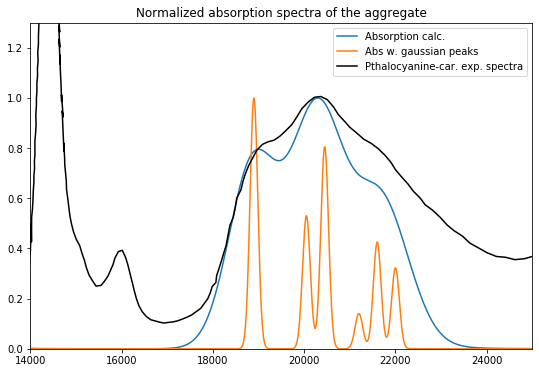

In [7]:
from matplotlib import pyplot as plt

# calculate absorption spectra
#---------------------------------------------
acalc = LinSpectrumCalculator(time,system=aggreg)
with energy_units("1/cm"):
    rwa_cm = aggreg.get_RWA_suggestion()
    print("Suggested RWA freq:",rwa_cm,"cm-1")
    acalc.bootstrap(rwa=rwa_cm,HWHH=100.0) # If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

# read experimental spectra
#---------------------------------------------
import csv
with open("exp_data/Carotenoid_exp_spec.csv", 'r') as f:
    reader = csv.reader(f)
    Abs_spec_nm = []
    Abs_spec_cm = []
    for row in reader:
        Abs_spec_nm.append([float(row[0]),float(row[1])])
        Abs_spec_cm.append([convert(float(row[0]),"nm","1/cm"),float(row[1])])
Abs_spec_nm = np.array(Abs_spec_nm,dtype='f8')
Abs_spec_cm = np.array(Abs_spec_cm,dtype='f8')

# plot normalized absorption spectra
#---------------------------------------------
with energy_units("1/cm"):
    plt.figure(figsize=(9,6))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-")
    #plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C0--")
    plt.plot(spectra["abs gauss"].axis.data,spectra["abs gauss"].data/np.max(spectra["abs gauss"].data),"C1")
    
    # Normalize absorption spectra
    Abs_spec_cm[:,1]=Abs_spec_cm[:,1]/max(Abs_spec_cm[:,1])/0.4727
    plt.plot(Abs_spec_cm[:,0],Abs_spec_cm[:,1],'k') 
    
    plt.legend(["Absorption calc.","Abs w. gaussian peaks","Pthalocyanine-car. exp. spectra"])
    #plt.legend(["Absorption","Fluorescence","Abs w. gaussian peaks","Pthalocyanine-car. exp. spectra"])
    plt.xlim([14000,25000])
    plt.ylim([0.0,1.3])

Calculate relaxation tensor
-------------

In [8]:
# initialize frequency axis
freq = time.get_FrequencyAxis()

# initialize rate matrix - only within ground and single excited states is important
Nsngl = np.sum(aggreg.Nb[:2]) # number of ground and single excited vibronic states
KK = np.zeros((Nsngl,Nsngl),dtype="f8")

with energy_units("1/cm"): 
    specD_vib = SpectralDensity(freq,cfce_params_vib)
    specD_el = [SpectralDensity(freq,cfce_params_elS1),
                SpectralDensity(freq,cfce_params_elS2)]

# Get fourier transform of correlation function
FT_cfce_el = []
for specD in specD_el:
    FT_cfce_el.append(specD.get_FTCorrelationFunction(temperature=Temp))
FT_cfce_vib = specD_vib.get_FTCorrelationFunction(temperature=Temp)

# Test of the axis length and step
kB_cmK = 0.69503476
with energy_units("1/cm"):
    resnum = np.real(FT_cfce_vib.at(-1522))/np.real(FT_cfce_vib.at(1522))
    resexp = np.exp(-1522/Temp/kB_cmK)
    print("Test of the time axis length and step:")
    print("  --Numerical C(-w)/C(w) :",resnum)
    print("  --Analytical C(-w)/C(w):",resexp)
    print("  --Difference C(-w)/C(w):",abs(resexp-resnum))

# Calculation of rates
vib1_freq = car.modes[0].get_energy(0)
vib2_freq = car.modes[1].get_energy(0)
ka = FT_cfce_vib.at(vib1_freq)
kb = FT_cfce_vib.at(vib2_freq)
k_a = FT_cfce_vib.at(-vib1_freq)
k_b = FT_cfce_vib.at(-vib2_freq)
k = [ka,kb]
k_ = [k_a,k_b]

# Construction of the rate matrix
for ii in range(0,Nsngl):
    for jj in range(0,Nsngl):
        elst1 = aggreg.vibsigs[ii][0][0]
        elst2 = aggreg.vibsigs[jj][0][0]
        if elst1 != elst2:
            # Electronic relaxation
            eng = aggreg.HH[jj,jj]-aggreg.HH[ii,ii]
            overlap = aggreg.FCf[ii,jj]**2
            indx = max([elst1,elst2])-1
            KK[ii,jj] = overlap * FT_cfce_el[indx].at(eng)    # Rate from jj->ii
            KK[jj,jj] -= overlap * FT_cfce_el[indx].at(eng)   # Sum of rates from jj
        else:      
            # Vibrational relaxation
            diff = np.array(aggreg.vibsigs[jj][1]) - np.array(aggreg.vibsigs[ii][1])
            nz = np.nonzero(diff)
            if nz[0].size == 1:                
                if diff[nz[0][0]] == 1:
                    KK[ii,jj] = aggreg.vibsigs[jj][1][nz[0][0]] * k[nz[0][0]]
                elif diff[nz[0][0]] == -1:
                    KK[ii,jj] = aggreg.vibsigs[ii][1][nz[0][0]] * k_[nz[0][0]]
                KK[jj,jj] -= KK[ii,jj]

Test of the time axis length and step:
  --Numerical C(-w)/C(w) : 0.000675948054734
  --Analytical C(-w)/C(w): 0.000675947520681
  --Difference C(-w)/C(w): 5.3405269226e-10


Calculate evolution superoperator
------------------

In [9]:
from quantarhei.qm import ProjectionOperator, ElectronicLindbladForm, SystemBathInteraction
from quantarhei.qm import EvolutionSuperOperator
from quantarhei import eigenbasis_of

# Set Limblad form relaxation
# -----------------------------------------
H = aggreg.get_Hamiltonian()

# Needed for limblad relaxation tensor projection to vibronic states
aggreg.sbi_mult = 1
aggreg.mult = 2
Nsngl = np.sum(aggreg.Nb[:2]) # number of ground and single excited vibronic states

if not aggreg._diagonalized:
    aggreg.diagonalize()

with eigenbasis_of(H): # For single molecule same as site basis
    indx = np.arange(aggreg.Ntot)
    indx = np.dot(aggreg.S1,indx).astype(int) # after diagonalization states are reordered according to energy  

    proj_operators = []
    rates = []

    # construct rate matrix for ground and single excited block (relaxation from the double excit. states is not important)
    # express upper part of the rate matrix as individual projectors and corresponding rates 
    for ii in range(Nsngl):
        for jj in range(Nsngl): # range(ii+1,aggreg_rt.Ntot):
            if ii!=jj:
                # projection operator from  the state jj to the state ii
                proj_operators.append(ProjectionOperator(ii, jj, dim=aggreg.Ntot))
                # rate jj->ii corresponding to the projection operator
                rates.append(KK[indx[ii],indx[jj]])

    sbi_proj = SystemBathInteraction(sys_operators=proj_operators, 
                                      rates=rates,system=aggreg)

# Set relaxation tensor and time axis
# ------------------------------------------
rt = ElectronicLindbladForm(H, sbi_proj)

# calculation of the evolution superoperator
eS = EvolutionSuperOperator(time_so, H, rt)
eS.set_dense_dt(100)
with eigenbasis_of(H):
    eS.calculate()

Plot vibronic state population evolution

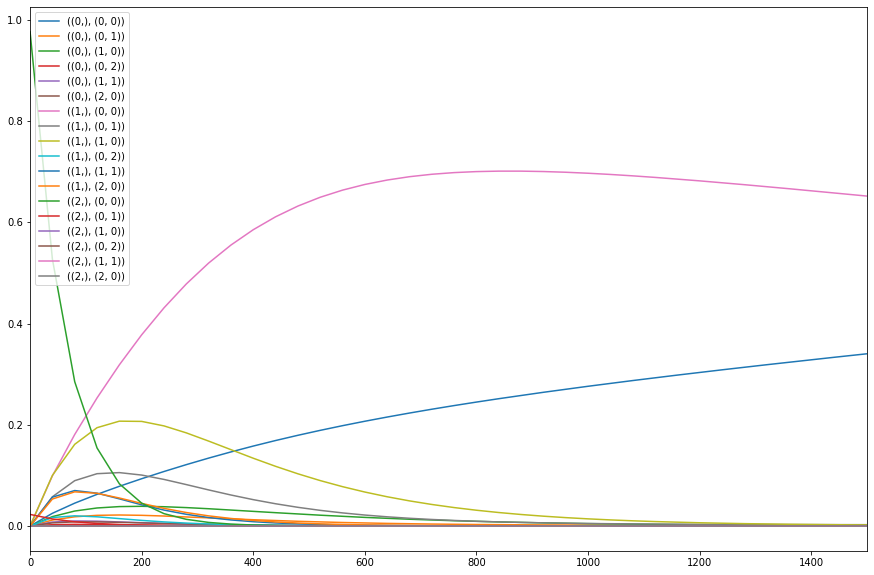

In [10]:
from quantarhei import ReducedDensityMatrix

rho = ReducedDensityMatrix(H.dim)
pop = np.sum(aggreg.DD[0]**2,axis=1)

# Multiply by pulse intensity
siteE = np.diag(H.data)
pulse = lab.pulse_f[0]
for ii in range(H.dim):
    pop[ii] *= pulse.at(siteE[ii])**2

# normalize populations:
pop = pop/np.sum(pop)
for ii in range(H.dim):
    rho.data[ii,ii] = pop[ii]

# Evolution of the density matrix
rhot_t = np.zeros((time_so.length,rho.dim,rho.dim),dtype="f8")
for n,T in enumerate(time_so.data):
    rhot_t[n] = np.real(eS.apply(T, rho).data)
    
plt.figure(figsize=(15,10))
legend = []
for ii in range(18):
    plt.plot(time_so.data,rhot_t[:,ii,ii])
    # After using diagonalize states are reordered acording to the energy
    legend.append(str(aggreg.vibsigs_engsort[ii]))
plt.xlim([0.0,1500.0])
plt.legend(legend)

# Calculate pump-probe spectra

In [11]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator            

rwa_cm = 18000

pcalc = PumpProbeSpectrumCalculator(time_so, t2D, system = aggreg)

with energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)
pcont = pcalc.calculate_all_system(aggreg, eS, lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


Plot pump-probe spectra

No handles with labels found to put in legend.


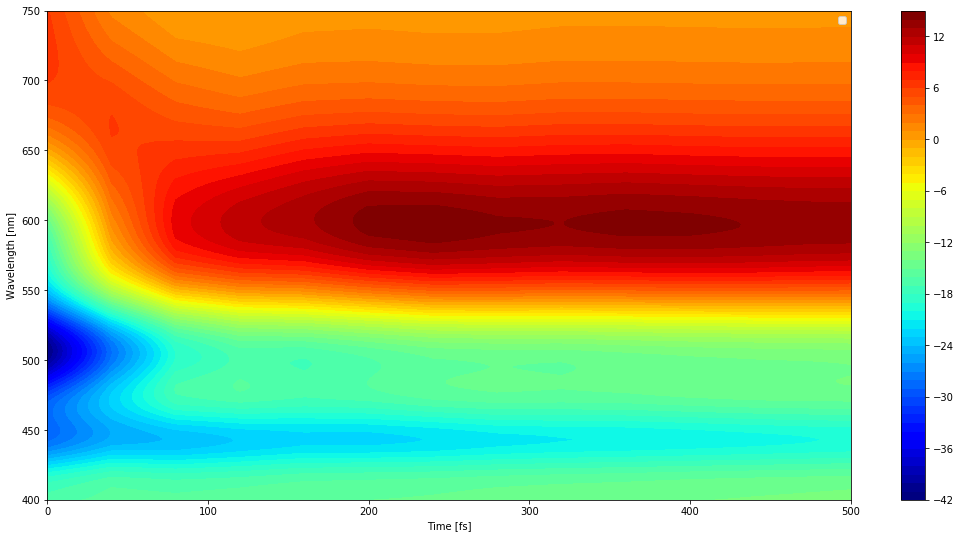

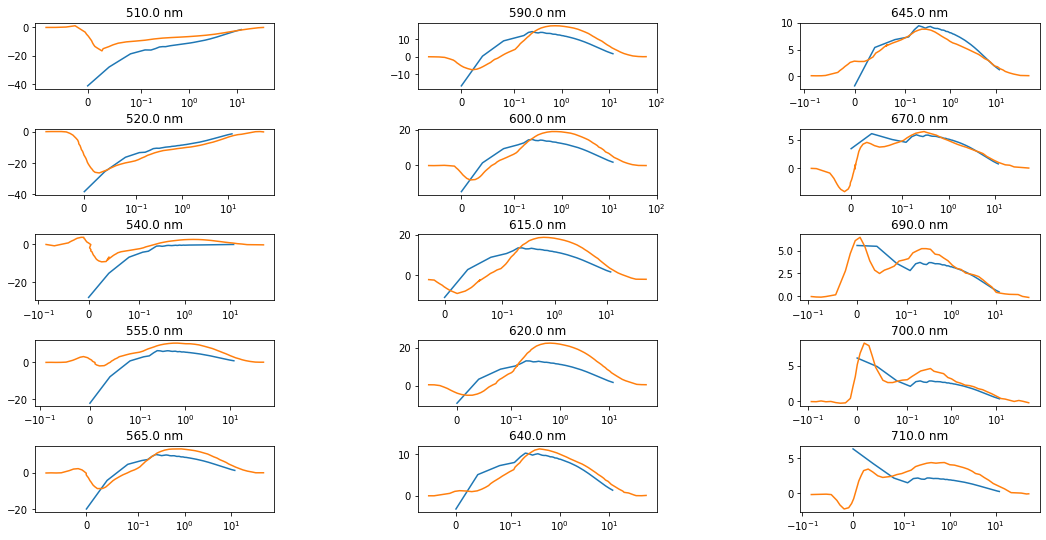

In [12]:
# load experimental spectra
#--------------------------------
PP_exp_spec = []
PP_exp_freq = []
count=0
with open('exp_data/PP_experiment_rescaled.csv', 'r') as f:
    reader = csv.reader(f)
    _is_freq = True
    for row in reader:
        if _is_freq:
            PP_exp_freq.append([])
            for element in row:
                if element != "":
                    PP_exp_freq[count].append(float(element))
            _is_freq = False
        else:
            PP_exp_spec.append([])
            for element in row:
                if element != "":
                    PP_exp_spec[count].append(float(element))
            _is_freq = True
            count += 1
            
# Plot pump probe spectra in 2D spectra
# -------------------------------------------------------
pcont.plot2D(axis = [[0, 500], [400, 750]], units = "nm", zero_centered = False)

# Plot calculated frequency slices and compare with experiment
#--------------------------------------------------------
expRes = {"frequency": PP_exp_freq,"intensity": PP_exp_spec}
freq_cut_nm = np.array([510,520,540,555,565,590,600,615,620,
                             640,645,670,690,700,710],dtype="f8")
spect = pcont.plot_slices(freq_cut_nm,expRes=expRes,units="nm")